<a href="https://colab.research.google.com/github/AlexanderWangY/DoodleGuesser/blob/main/model/DrawingDetectorModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda, Resize, Grayscale
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tqdm import tqdm
import copy

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
dataset_path = '/content/drive/MyDrive/drawings_dataset'

In [ ]:
transform = transforms.Compose([
    ToTensor(),
    Resize((100, 100)),
    Grayscale(),
])

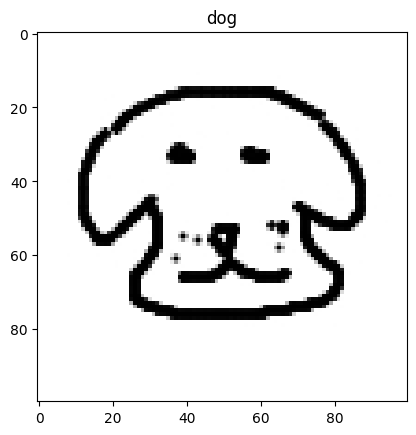

In [ ]:
drawing_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
classes = drawing_dataset.classes

plt.title(classes[drawing_dataset[12][1]])
plt.imshow(drawing_dataset[12][0].squeeze(), cmap='gray')
plt.show()

In [ ]:
# Ok, let's split them into train and validation datasets now!

trn_size = int(0.85 * len(drawing_dataset))
val_size = int(len(drawing_dataset) - trn_size)

trn_dataset, val_dataset = random_split(drawing_dataset, [trn_size, val_size])

trn_loader = DataLoader(trn_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

In [ ]:
len(trn_dataset), len(val_dataset)

(255, 45)

In [ ]:
# Let's define our model!

class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
    self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)
    self.drop1 = nn.Dropout(.25)
    self.drop2 = nn.Dropout(.5)
    self.fc1 = nn.Linear(128 * 50 * 50, 256) # Shape gets cut in half due to max pooling! (100 x 100) -> (50 x 50)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 5)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.conv3(x)
    x = F.relu(x)
    x = self.drop1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.drop2(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    output = F.log_softmax(x, dim=-1)
    return output


In [ ]:
model = ConvNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
BATCH_SIZE = 16
loss_per_epoch = []

def test(model):
  model.eval()
  correct = 0
  avg_loss = 0
  with torch.no_grad():
    for Xb, yb in val_loader:
      Xb, yb = Xb.to(device), yb.to(device)
      y_pred = model(Xb)
      pred = y_pred.argmax(-1)
      avg_loss += loss_fn(y_pred, yb)
      correct += pred.eq(yb.view_as(pred)).sum().item()

  print(f"Correct: {correct} out of {len(val_loader) * BATCH_SIZE}")
  print(f"Accuracy: {correct / (len(val_loader) * BATCH_SIZE) * 100:.2f}%")
  print(f"Avg Loss: {avg_loss / len(val_loader):.2f}")
  loss_per_epoch.append(round((avg_loss / len(val_loader)).item(), 4))

epochs = 10

for e in range(epochs):
  torch.cuda.empty_cache()
  model.train()
  epoch_loss = 0
  for Xb, yb in tqdm(trn_loader):
    Xb, yb = Xb.to(device), yb.to(device)
    optimizer.zero_grad()
    y_pred = model(Xb)
    loss = loss_fn(y_pred, yb)
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

  print(f"Epoch {e} ---- Loss: {epoch_loss:.5f}")
  test(model)

epochs = np.arange(epochs)
plt.plot(epochs, loss_per_epoch)
plt.xlabel = "Epoch"
plt.ylabel = "Avg Loss"
plt.title("Avg Loss per Epoch")
plt.show()

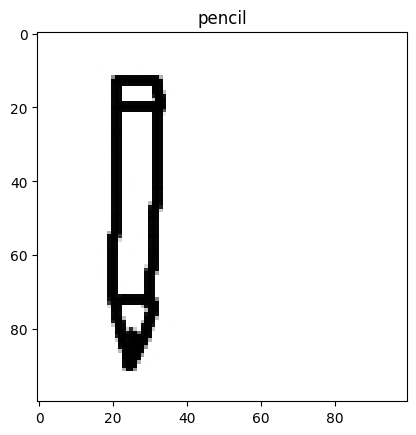

In [ ]:
index = 7

img = val_dataset[index][0].unsqueeze(0) # Adding dimension for batch
label = classes[val_dataset[index][1]]

plt.title(label)
plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
pred = model(img.to(device))
pred_class = classes[pred.argmax(dim=1).item()]

print(f"I think its a {pred_class}!")
print(f"Truthfully, it was a(n) {label}!")

I think its a pencil!
Truthfully, it was a(n) pencil!


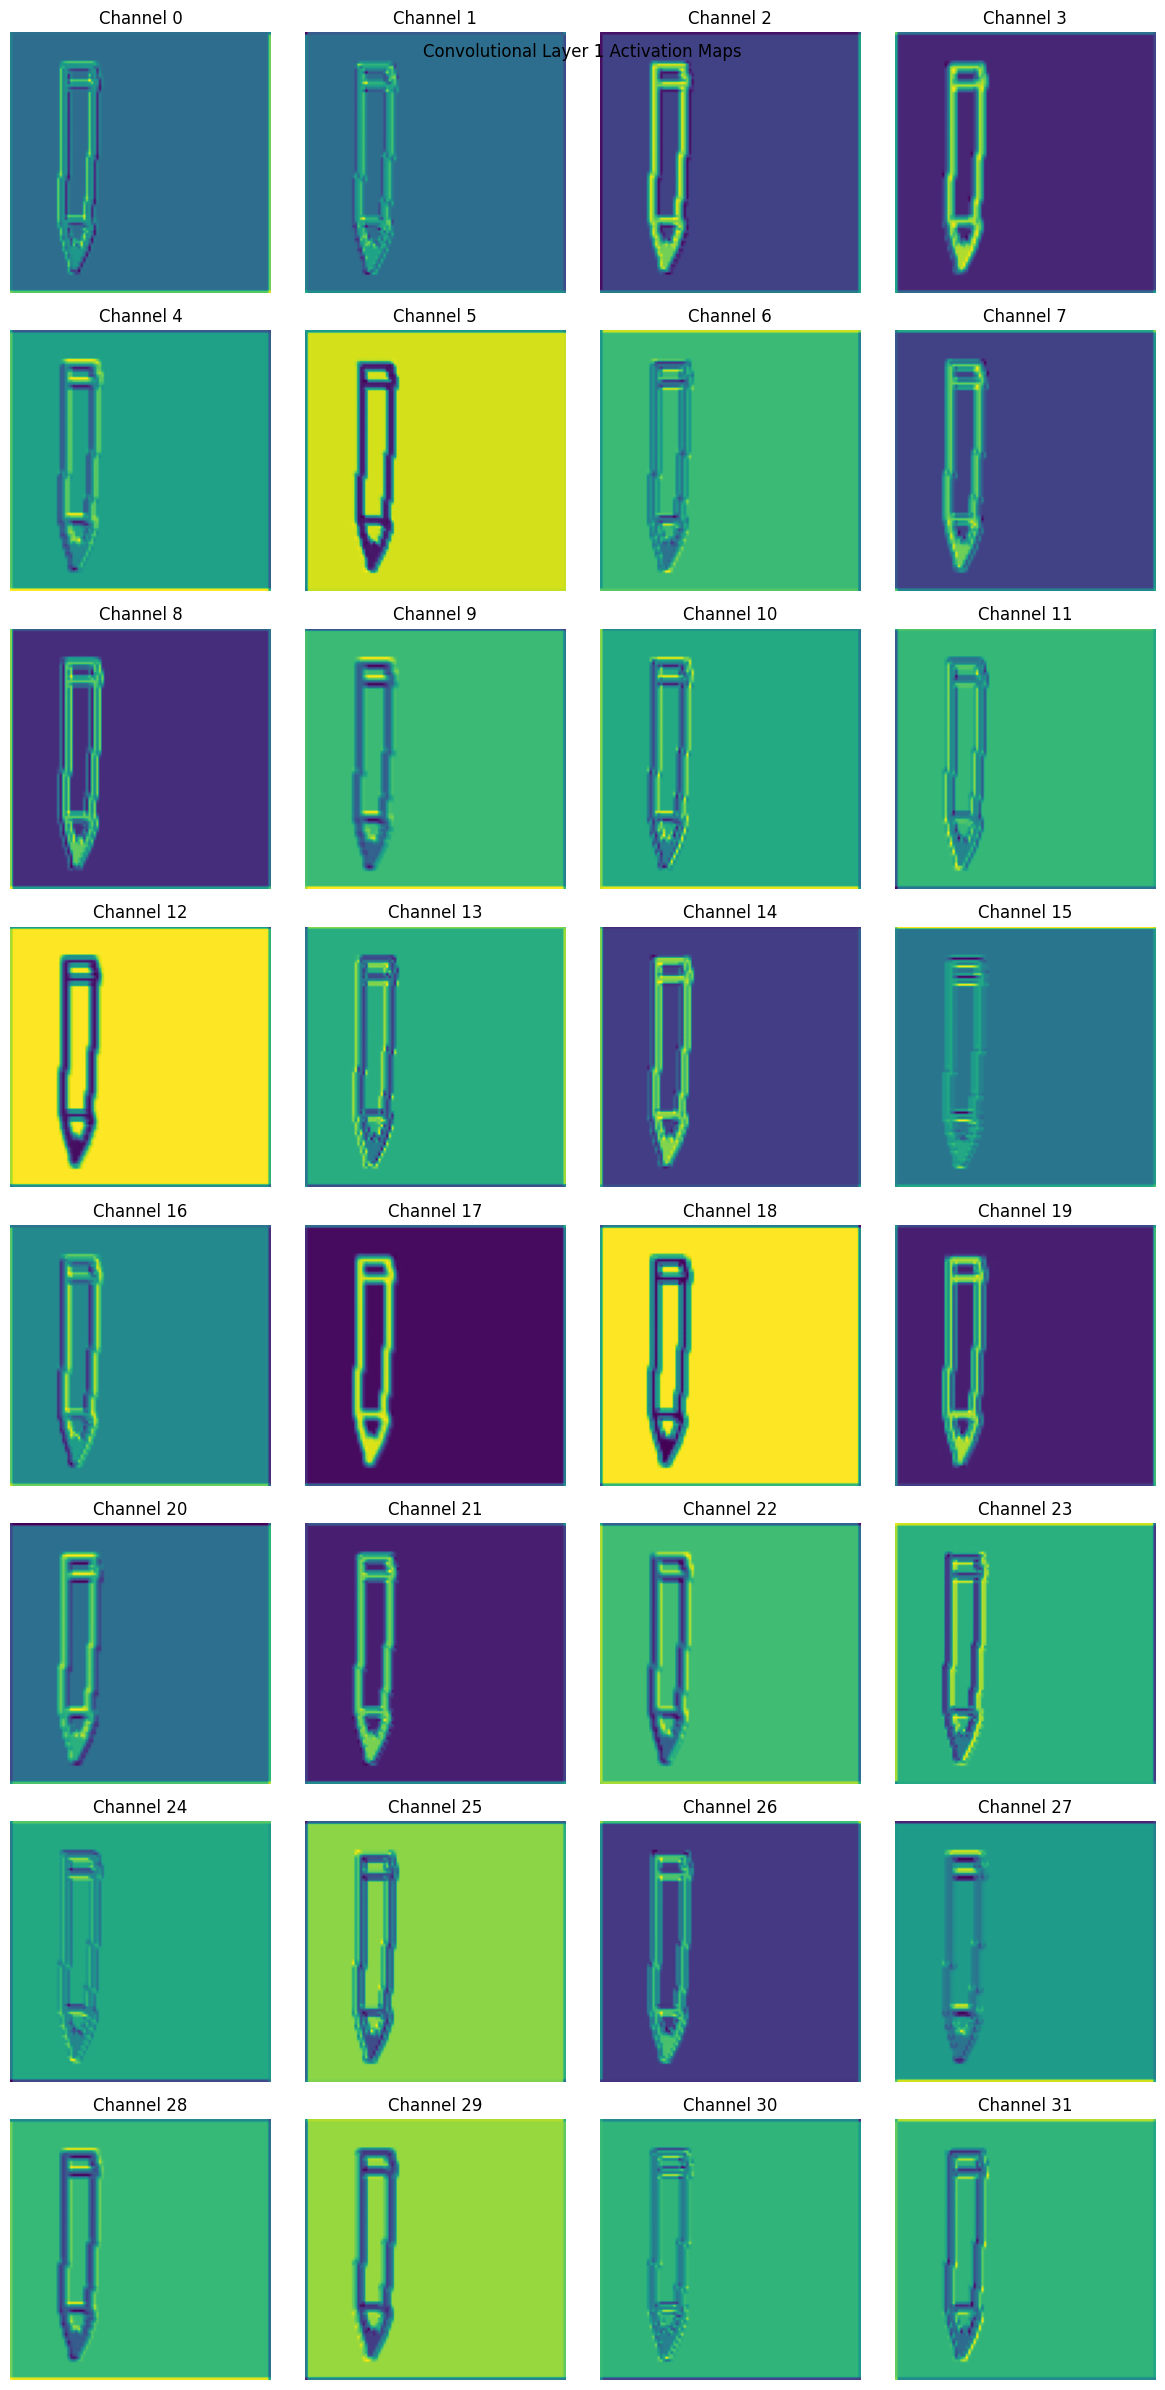

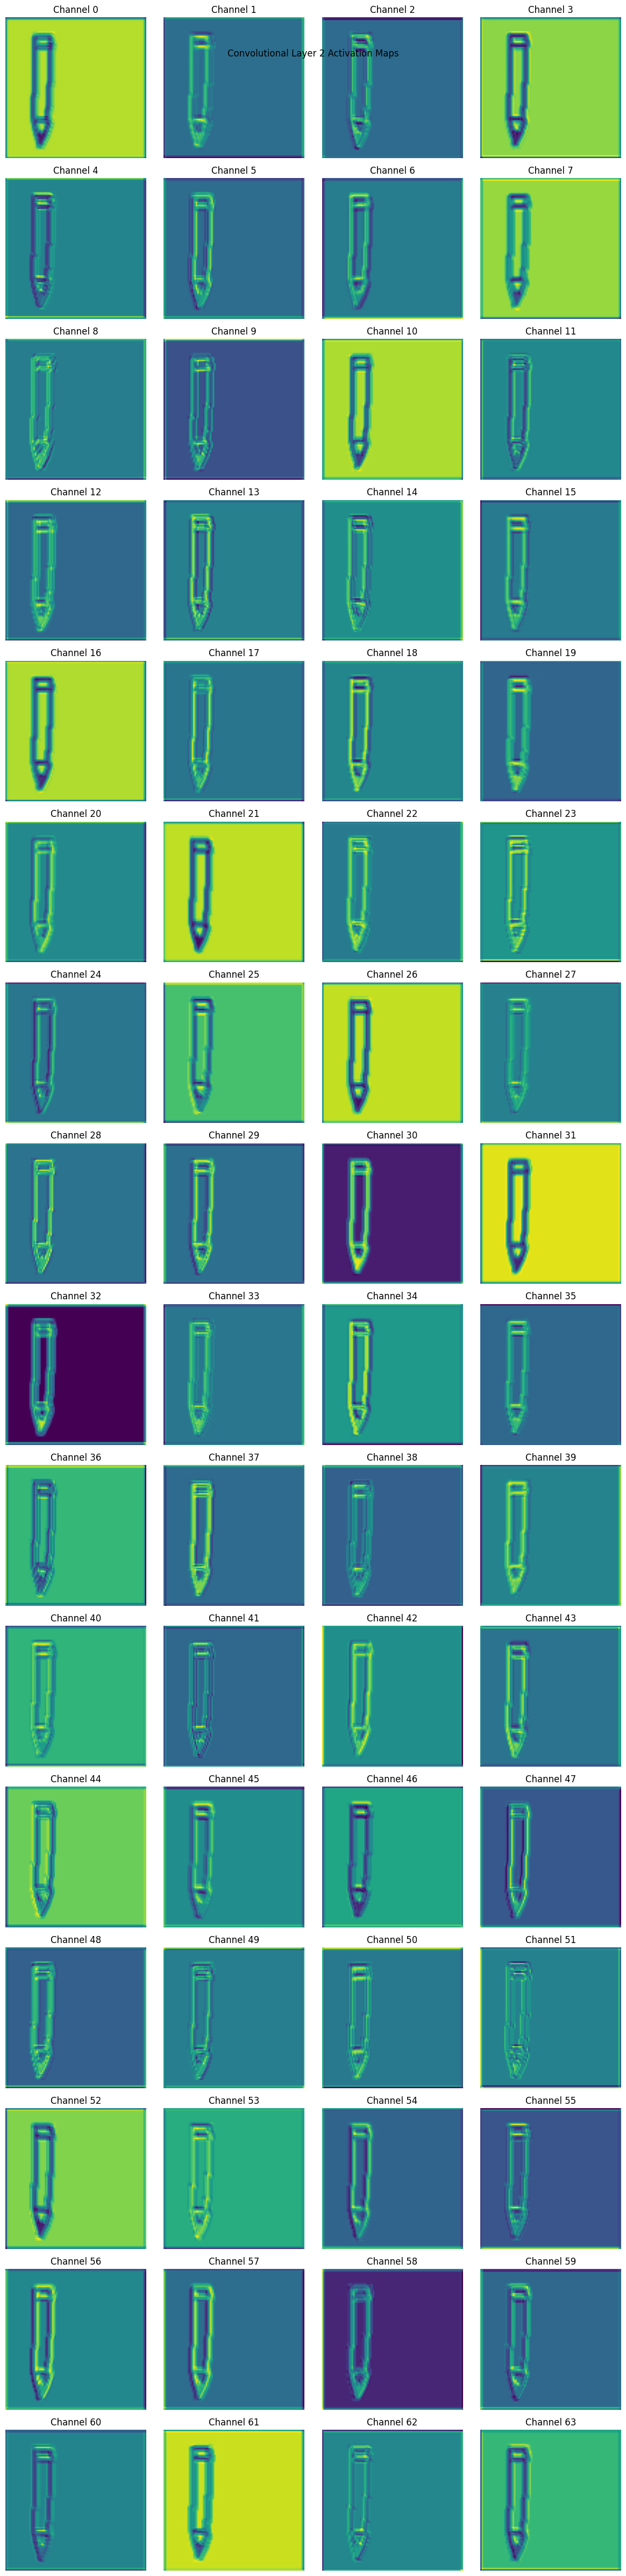

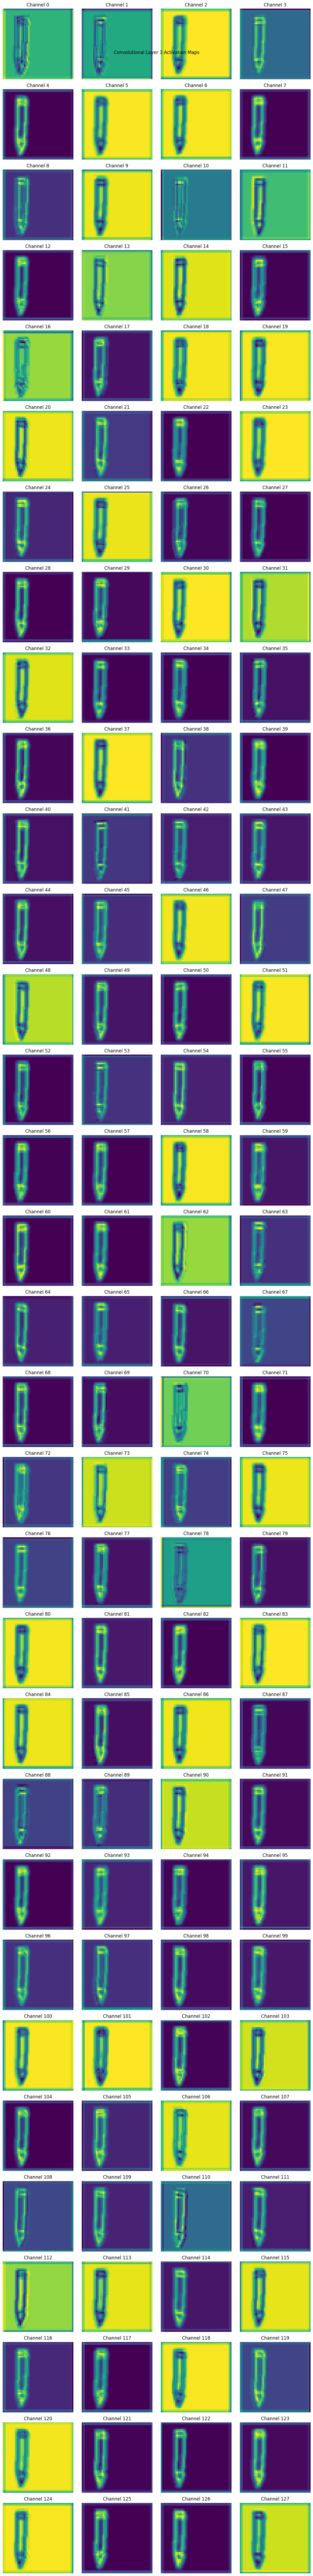

In [ ]:
def visualize_activation_maps(model, input_image):
    activations = []
    def hook(module, input, output):
        activations.append(output)

    # Register hook to collect activations from convolutional layers
    model.conv1.register_forward_hook(hook)
    model.conv2.register_forward_hook(hook)
    model.conv3.register_forward_hook(hook)

    # Forward pass
    model.eval()
    with torch.no_grad():
        model(input_image)

    # Plot activation maps
    for i, activation_map in enumerate(activations):
        num_channels = activation_map.shape[1]
        rows = (num_channels + 3) // 4  # Determine number of rows for subplots
        fig, axes = plt.subplots(rows, 4, figsize=(12, 3 * rows))  # Adjust figsize for better spacing

        for j, ax in enumerate(axes.flat):
            if j < num_channels:
                ax.imshow(activation_map[0, j].cpu().numpy(), cmap='viridis')
                ax.axis('off')
                ax.set_title(f'Channel {j}')
            else:
                ax.axis('off')  # Hide empty subplot

        # Adjust layout to prevent overlap of subplots and ensure readability
        plt.tight_layout()
        plt.suptitle(f'Convolutional Layer {i+1} Activation Maps')
        plt.show()

visualize_activation_maps(model, img.to(device))

In [ ]:
img = Image.open("./dog_test1.jpg")
img = transform(np.array(img)).unsqueeze(0)

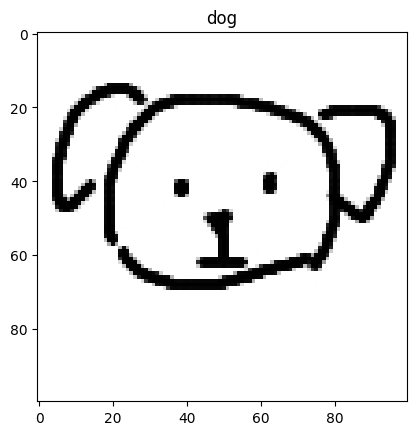

In [ ]:
plt.title("dog")
plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
pred = model(img.to(device))
pred_class = classes[pred.argmax(dim=1).item()]

print(f"I think its a {pred_class}!")
print(f"Truthfully, it was a(n) dog!")

I think its a dog!
Truthfully, it was a(n) dog!


In [ ]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(model, test_loader, classes):
    # Make sure your model is in evaluation mode
    model.eval()

    # Initialize lists to store true labels and predicted labels
    true_labels = []
    pred_labels = []

    # Iterate over the test data and collect predictions
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predicted.cpu().numpy())

    # Create confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)

    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Print the confusion matrix values
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
plot_confusion_matrix(model, val_loader, classes)

In [ ]:
torch.save(model, "best.pt")

AttributeError: Can't pickle local object 'visualize_activation_maps.<locals>.hook'